# FEATURE PRE-SELECTION

In this stage, we identify which variables are most useful for predicting the Remaining Useful Life (RUL). The goal is to keep only the features that add real value and remove those that are redundant. 

Based on experience, we will use these methods to check for redundancy: 

Supervised methods:
- Mutual Information
- Recursive Feature Elimination (RFE)
- Permutation Importance to measure feature relevance, 

Non-supervised method:
- Correlation Analysis 

## IMPORT LIBRARIES

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance


#Autocomplete
%config IPCompleter.greedy=True

## IMPORT DATA

In [116]:
WORK_PATH = '/Users/rober/cmapss-rul-prediction/02_Data/03_Working/'

In [117]:
name_df = 'df_analytical_base.pickle'

In [118]:
df = pd.read_pickle(WORK_PATH + name_df)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14507 entries, 0 to 14506
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sensor_14_yeo      14507 non-null  float64
 1   sensor_9_qt        14507 non-null  float64
 2   time_in_cycles_ss  14507 non-null  float64
 3   sensor_2_ss        14507 non-null  float64
 4   sensor_3_ss        14507 non-null  float64
 5   sensor_4_ss        14507 non-null  float64
 6   sensor_7_ss        14507 non-null  float64
 7   sensor_8_ss        14507 non-null  float64
 8   sensor_11_ss       14507 non-null  float64
 9   sensor_12_ss       14507 non-null  float64
 10  sensor_13_ss       14507 non-null  float64
 11  sensor_15_ss       14507 non-null  float64
 12  sensor_20_ss       14507 non-null  float64
 13  sensor_21_ss       14507 non-null  float64
 14  RUL                14507 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


## SUPERVISED METHODS

### Separate X and y

In [120]:
target = 'RUL'
X = df.drop(columns=target).copy()
y = df[target].copy()

### Mutual Information

#### Create a function to show the output

In [121]:
def ranking_mi(mutual_selector, mode='table'):
    # Build the ranking table
    ranking_mi = pd.DataFrame(mutual_selector, index=X.columns).reset_index()
    ranking_mi.columns = ['variable', 'mi_importance']
    ranking_mi = ranking_mi.sort_values(by='mi_importance', ascending=False)
    ranking_mi['mi_rank'] = np.arange(0, ranking_mi.shape[0])    
    # Display the output
    if mode == 'table':
        return ranking_mi
    else:
        g = ranking_mi.mi_importance.sort_values().plot.barh(figsize=(10, 10))
        g.set_yticklabels(ranking_mi.sort_values(by='mi_importance').variable)
        return g

#### Calculate and check

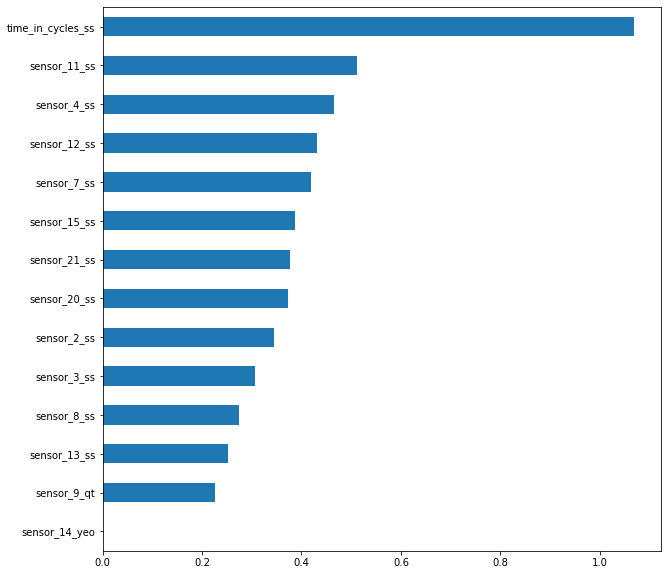

In [122]:
mutual_selector = mutual_info_regression(X,y)

rank_mi = ranking_mi(mutual_selector, mode = 'plot')

#### Select top N features

In Mutual Information, a natural cutoff usually appears where the MI value drops by more than 20–30% relative to the previous feature.

- There’s a clear gap after about feature #8 or #9 (around 0.3 MI).
- Beyond that, the contribution flattens.

**✅ We'll keep the top 8 features.**

That keeps a balance between:
- Capturing the main predictive variables
- Avoiding redundancy or weak signals
- Leaving enough features for later methods (RFE, Permutation Importance) to validate or refine.

##### Position of the last feature

In [123]:
position_limit_feature = 8

##### Extract names of selected variables

In [124]:
include_mi = ranking_mi(mutual_selector).iloc[0:position_limit_feature].variable

##### Create dataframe with selected variables

In [125]:
X_mi = X[include_mi].copy()

### Recursive Feature Elimination

#### Instance

In [126]:
rfe = RFE(
        estimator=XGBRegressor(
                n_jobs=-1, # Use all CPU cores to speed up training
                random_state=42, # Ensures reproducible results (same random splits/initialization each run)
                objective='reg:squarederror'), # Standard regression objective for continuous targets (like RUL)
        n_features_to_select=8 # Number of features to keep after recursive elimination
        )

#### Train

In [127]:
rfe.fit(X,y)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, device=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None, gamma=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=None, n_jobs=-1, num_parallel_tree=None,
                           random_state=42, ...),
    n_features_to_select=8)

#### Extract names of selected variables

In [128]:
include_rfe = X.columns[rfe.support_]

#### Create dataframe with selected variables

In [129]:
X_rfe = X[include_rfe].copy()

In [130]:
X_rfe.columns.to_list()

['sensor_9_qt',
 'time_in_cycles_ss',
 'sensor_4_ss',
 'sensor_7_ss',
 'sensor_8_ss',
 'sensor_11_ss',
 'sensor_12_ss',
 'sensor_15_ss']

### Permutation Importance

#### Create a function to show the output

In [131]:
def ranking_per(predictors,permutation):
    ranking_per = pd.DataFrame({'variable': predictors.columns, 'importance_per': permutation.importances_mean}).sort_values(by = 'importance_per', ascending = False)
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    return(ranking_per)

#### Instance and train

In [132]:
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

xgb = XGBRegressor(n_jobs = -1,                    # Use all CPU cores
                   random_state = 42,              # Ensures reproducible results
                   objective = 'reg:squarederror') # Standard regression objective for continuous targets (like RUL)

xgb.fit(X,y)

permutation = permutation_importance(
    xgb,
    X,
    y,
    scoring = 'neg_root_mean_squared_error', # larger (less negative) values are better
    n_repeats = 5,
    n_jobs = -1,
    random_state = 42
)

#### Check the output

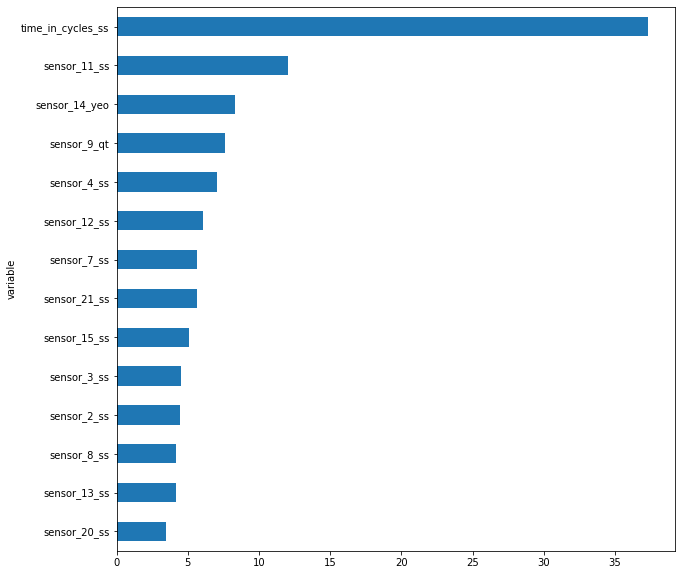

In [133]:
rank_per = ranking_per(X,permutation)

rank_per.set_index('variable').importance_per.sort_values().plot.barh(figsize = (10,10));

#### Select variables to include

##### Position of the last variable to include

In [134]:
position_limit_feature = 8

##### Extract names of selected variables

In [135]:
include_per = rank_per.iloc[0:position_limit_feature].variable

##### Create dataframe with selected variables

In [136]:
X_per = X[include_per].copy()

## SELECT METHOD

**Mutual Information** is the selected method because it gives stable, interpretable results without depending on a specific model. 

- All three methods agree on a core subset of highly informative features:
**time_in_cycles_ss, sensor_11_ss, sensor_4_ss, sensor_12_ss, sensor_7_ss**, with time_in_cycles_ss as the strongest feature

- RFE and PI also highlight **sensor_9_qt** and **sensor_14_yeo** as useful... but not consistently enough to change the final selection.

Comments: 

- In MI and PI, time_in_cycles_ss is the strongest feature
- Many top sensors (sensor_11_ss, sensor_4_ss, sensor_12_ss, sensor_7_ss, etc.) appear in both lists
- Only a few minor differences appear: sensor_9_qt, sensor_14_yeo show up in PI but not MI.

Also: 
- Based on experience, MI captures both linear and nonlinear relationships between features and the RUL target, making it a reliable way to identify variables that truly contribute to prediction performance.

These methods provide a model-based view of variable relevance: 
- _Recursive Feature Elimination (RFE)_ evaluates how features affect the model step by step
- _Permutation Importance_ measures the real performance impact of each variable. 

Using them alongside, Mutual Information helps validate our selection and ensures the most important features are consistently identified across different approaches.

In [137]:
X_preselected = X_mi
# X_preselected = X_rfe
# X_preselected = X_per

## NON SUPERVISED METHODS

### Correlation

#### Create a function to show the output

In [138]:
def strong_corr(df, low_limit=0.3, high_limit=1, drop_dupli=True):
    """
    Finds pairs of variables that have strong correlations between them.
    """
    # Calculate the absolute correlation matrix
    c = df.corr().abs()

    # Convert the matrix to long format (flatten all pairs into rows)
    c = c.unstack()

    # Move the index to columns and rename them
    c = pd.DataFrame(c).reset_index()
    c.columns = ['var1', 'var2', 'corr']

    # Convert to a DataFrame, filter correlations within limits, and sort descending
    c = c.loc[(c['corr'] > low_limit) & (c['corr'] < high_limit), :].sort_values(by='corr', ascending=False)

    # Remove duplicate correlations (unless drop_dupli is set to False)
    c = c if not drop_dupli else c.drop_duplicates(subset=['corr'])

    # Return the resulting table
    return c

#### Calculate and check

##### Calculate

In [139]:
final_corr = strong_corr(X_preselected)

##### Check

In [140]:
final_corr.var1.value_counts()

sensor_12_ss         5
sensor_15_ss         5
sensor_20_ss         4
sensor_21_ss         4
sensor_7_ss          3
time_in_cycles_ss    3
sensor_4_ss          2
sensor_11_ss         2
Name: var1, dtype: int64

##### Check in detail

In [141]:
final_corr.head(50)

,var1,var2,corr
25,sensor_12_ss,sensor_11_ss,0.846789
17,sensor_4_ss,sensor_11_ss,0.828467
12,sensor_11_ss,sensor_7_ss,0.822210
28,sensor_12_ss,sensor_7_ss,0.812373
26,sensor_12_ss,sensor_4_ss,0.812333
34,sensor_7_ss,sensor_4_ss,0.788540
41,sensor_15_ss,sensor_11_ss,0.779568
57,sensor_20_ss,sensor_11_ss,0.769218
14,sensor_11_ss,sensor_21_ss,0.768829
43,sensor_15_ss,sensor_12_ss,0.763984


#### Filter variables

Function to drop variables with high correlation

In [87]:
# Define correlation threshold
corr_threshold = 0.85

# Initialize a set to track variables to drop
to_drop = set()

for _, row in final_corr.iterrows():
    var1, var2, corr_value = row
    if corr_value > corr_threshold:
        # Drop var2 if var1 is not already dropped
        if var1 not in to_drop:
            to_drop.add(var2)

print("Variables to drop due to high correlation:")
print(to_drop)

# Create filtered dataset
X_corr_filtered = X_preselected.drop(columns=list(to_drop), errors='ignore')
X_corr_filtered.shape

Variables to drop due to high correlation:
set()


(14507, 8)

**No correlation pair exceeded our threshold of 0.85** — There are no redundant variables among our already preselected features (X_preselected)

In [88]:
X_preselected.columns.to_list()

['time_in_cycles_ss',
 'sensor_11_ss',
 'sensor_4_ss',
 'sensor_12_ss',
 'sensor_7_ss',
 'sensor_15_ss',
 'sensor_21_ss',
 'sensor_20_ss']

## SAVE DATASETS AFTER FEATURE PRESELECTION

In [89]:
#Set names
name_X_preselected = WORK_PATH + 'X_preselected.pickle'
name_y_preselected = WORK_PATH + 'y_preselected.pickle'

In [90]:
#Save files
X_preselected.to_pickle(name_X_preselected)

y_preselected = y.copy()
y_preselected.to_pickle(name_y_preselected)

In [91]:
#Save names of selected variables
PROJECT_PATH = '/Users/rober/cmapss-rul-prediction/'
names_selected_variables = PROJECT_PATH  + '/05_Results/' + 'selected_variables.pickle'

pd.Series(X_preselected.columns).to_pickle(names_selected_variables)